## Multinomial Naive Bayes Implementation on scaled non-reduced dataset

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
seed = 23

In [4]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

In [5]:
#df_scaled_sample = df_scaled.sample(n=1000, random_state=seed)
df_scaled_sample = df_scaled

In [6]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1),
    df_scaled_sample['averageRating'], test_size=test_size,
    random_state=seed
)

In [7]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }

    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")

    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()

    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()

    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])

    return df_metrics

In [13]:
X_train.fillna(0.0, inplace=True)
y_train.fillna(0.0, inplace=True)
model = MultinomialNB()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.6624203821656051
F1 score: [0.72866894 0.55337079]


In [16]:
param_grid = {
    'alpha' : [0.5, 0.75, 1.0],
    'fit_prior' : [True, False]
}

model = MultinomialNB()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
The parameters with the highest score:  {'alpha': 0.5, 'fit_prior': False}


In [17]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                params  mean_test_score
1   {'alpha': 0.5, 'fit_prior': False}         0.680467
3  {'alpha': 0.75, 'fit_prior': False}         0.680467
5   {'alpha': 1.0, 'fit_prior': False}         0.680202
0    {'alpha': 0.5, 'fit_prior': True}         0.665605
2   {'alpha': 0.75, 'fit_prior': True}         0.664809
4    {'alpha': 1.0, 'fit_prior': True}         0.664809


Metrics for MNB-GS-CV1:
Accuracy: 0.6773
Weighted F1: 0.6735
Weighted Precision: 0.6750
Weighted Recall: 0.6773
Macro-Averaged Precision: 0.6728
Macro-Averaged Recall: 0.6649
F1: [0.72710952 0.60519481]
Precision: [0.69112628 0.65449438]
classification report
              precision    recall  f1-score   support

     Class 0       0.69      0.77      0.73       528
     Class 1       0.65      0.56      0.61       414

    accuracy                           0.68       942
   macro avg       0.67      0.66      0.67       942
weighted avg       0.68      0.68      0.67       942

Confusion Matrix


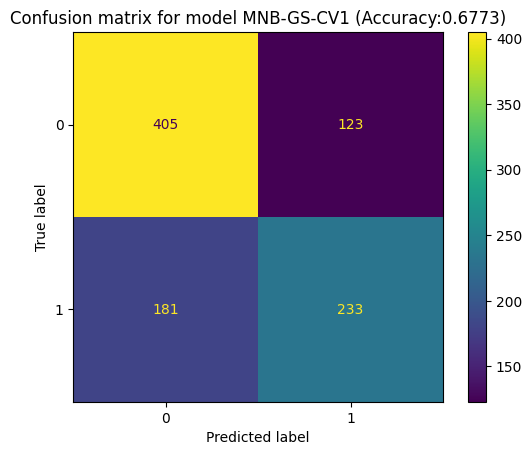

In [19]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('MNB-GS-CV1', y_test, predictions)

In [21]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(5):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = MultinomialNB(**params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'alpha': 0.5, 'fit_prior': False}
Accuracy for chosen parameters: 0.6772823779193206
Parameters from place:  1   {'alpha': 0.75, 'fit_prior': False}
Accuracy for chosen parameters: 0.6772823779193206
Parameters from place:  2   {'alpha': 1.0, 'fit_prior': False}
Accuracy for chosen parameters: 0.6772823779193206
Parameters from place:  3   {'alpha': 0.5, 'fit_prior': True}
Accuracy for chosen parameters: 0.6624203821656051
Parameters from place:  4   {'alpha': 0.75, 'fit_prior': True}
Accuracy for chosen parameters: 0.6624203821656051


In [23]:
# get best from top 5
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [24]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.6772823779193206
{'alpha': 0.5, 'fit_prior': False}


In [26]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(5):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = MultinomialNB(**params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'alpha': 0.5, 'fit_prior': False}
Accuracy for chosen parameters: 0.684447983014862
Parameters from place:  1   {'alpha': 0.75, 'fit_prior': False}
Accuracy for chosen parameters: 0.684447983014862
Parameters from place:  2   {'alpha': 1.0, 'fit_prior': False}
Accuracy for chosen parameters: 0.6847133757961783
Parameters from place:  3   {'alpha': 0.5, 'fit_prior': True}
Accuracy for chosen parameters: 0.6698513800424628
Parameters from place:  4   {'alpha': 0.75, 'fit_prior': True}
Accuracy for chosen parameters: 0.6698513800424628


In [29]:
best_accuracy = 0
best_report = None
best_predictions = None
y_best_predictions = None
all_reports = []

for i in range(100):
  random_state_fit = np.random.randint(1000)

  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1),
    df_scaled_sample['averageRating'], test_size=test_size,
    random_state=random_state_fit)

  X_train.fillna(0.0, inplace=True)
  y_train.fillna(0.0, inplace=True)
  X_test.fillna(0.0, inplace=True)
  y_test.fillna(0.0, inplace=True)

  model = MultinomialNB(**best_tuple[1])
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  current_accuracy = accuracy_score(y_test, predictions)

  report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
  all_reports.append(report)
  print(current_accuracy)

  if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_report = report
        best_predictions = predictions
        y_best_predictions = y_test

def average_classification_report(reports):
    metrics = ['precision', 'recall', 'f1-score']
    avg_report = {}
    for metric in metrics:
        avg_report[metric] = sum(r['macro avg'][metric] for r in reports) / len(reports)
    avg_report['accuracy'] = sum(r['accuracy'] for r in reports) / len(reports)
    return avg_report

avg_report = average_classification_report(all_reports)

print("Best Classification Report:")
print(classification_report(y_best_predictions, best_predictions, zero_division=0))
print("Best Accuracy:", best_accuracy)
print()
print("Average Classification Report:")
for metric, score in avg_report.items():
    print(f"{metric}: {score:.4f}")

0.6666666666666666
0.6656050955414012
0.6804670912951167
0.6878980891719745
0.667728237791932
0.648619957537155
0.673036093418259
0.6762208067940552
0.6581740976645435
0.6878980891719745
0.678343949044586
0.6698513800424628
0.673036093418259
0.6836518046709129
0.6825902335456475
0.6719745222929936
0.673036093418259
0.678343949044586
0.6571125265392781
0.667728237791932
0.6624203821656051
0.6751592356687898
0.6687898089171974
0.6772823779193206
0.6900212314225053
0.6709129511677282
0.6645435244161358
0.6698513800424628
0.6687898089171974
0.6815286624203821
0.673036093418259
0.6719745222929936
0.6942675159235668
0.6889596602972399
0.6560509554140127
0.692144373673036
0.648619957537155
0.667728237791932
0.6762208067940552
0.6634819532908705
0.6411889596602972
0.6549893842887473
0.7048832271762208
0.6794055201698513
0.678343949044586
0.6868365180467091
0.6634819532908705
0.6772823779193206
0.648619957537155
0.6634819532908705
0.6751592356687898
0.6868365180467091
0.692144373673036
0.679405

Metrics for MNB-Shuffled_best:
Accuracy: 0.7049
Weighted F1: 0.7026
Weighted Precision: 0.7034
Weighted Recall: 0.7049
Macro-Averaged Precision: 0.7015
Macro-Averaged Recall: 0.6953
F1: [0.74635036 0.64720812]
Precision: [0.71754386 0.68548387]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.78      0.75       526
     Class 1       0.69      0.61      0.65       416

    accuracy                           0.70       942
   macro avg       0.70      0.70      0.70       942
weighted avg       0.70      0.70      0.70       942

Confusion Matrix


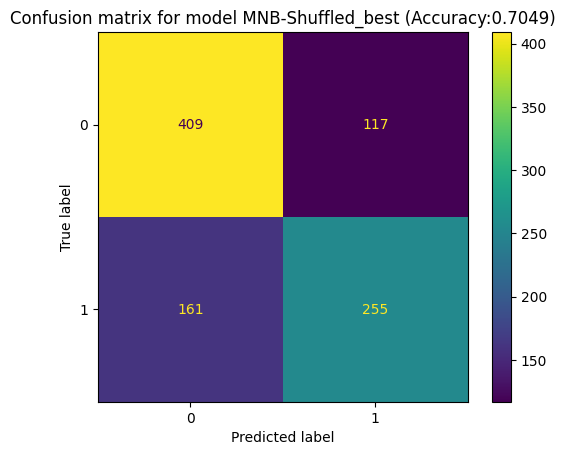

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
MNB-Shuffled_best,0.704883,0.702568,0.703386,0.704883,0.701514,0.695274,[0.74635036 0.64720812],[0.71754386 0.68548387]


In [30]:
calculate_metrics('MNB-Shuffled_best', y_best_predictions, best_predictions)